We will use the Movie Lens datasets to get suggestions for **Movies to watch** based on collaborative filtering

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Importing and merging  the movie lens data

In [25]:
mldf=pd.read_csv('u_data.csv',sep='\t',names=['user_id','movie_id','rating','time'])

In [26]:
mldf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100003 entries, 0 to 100002
Data columns (total 4 columns):
user_id     100003 non-null int64
movie_id    100003 non-null int64
rating      100003 non-null int64
time        100003 non-null int64
dtypes: int64(4)
memory usage: 3.1 MB


In [27]:
mtitledf=pd.read_csv('Movie_Id_Titles.csv',names=['movie_id','movie_name'],skiprows=1)

In [28]:
mtitledf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1682 entries, 0 to 1681
Data columns (total 2 columns):
movie_id      1682 non-null int64
movie_name    1682 non-null object
dtypes: int64(1), object(1)
memory usage: 26.4+ KB


In [30]:
MLdf_merged=mldf.merge(mtitledf)

In [31]:
MLdf_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100003 entries, 0 to 100002
Data columns (total 5 columns):
user_id       100003 non-null int64
movie_id      100003 non-null int64
rating        100003 non-null int64
time          100003 non-null int64
movie_name    100003 non-null object
dtypes: int64(4), object(1)
memory usage: 4.6+ MB


Exploratory Data analysis on Movie lens data

Analysis of which movies has highest average  rating and highest number of watches

In [40]:
MLdf_merged.groupby('movie_name')['rating'].mean().sort_values(ascending=False).head()

movie_name
Marlene Dietrich: Shadow and Light (1996)     5.0
Prefontaine (1997)                            5.0
Santa with Muscles (1996)                     5.0
Star Kid (1997)                               5.0
Someone Else's America (1995)                 5.0
Name: rating, dtype: float64

In [41]:
MLdf_merged.groupby('movie_name')['rating'].count().sort_values(ascending=False).head()

movie_name
Star Wars (1977)             584
Contact (1997)               509
Fargo (1996)                 508
Return of the Jedi (1983)    507
Liar Liar (1997)             485
Name: rating, dtype: int64

Plotting highest rating,view distribution

In [56]:
MLdf_cleansed=pd.DataFrame(data=MLdf_merged.groupby('movie_name')['rating'].mean())
MLdf_cleansed['total views']=pd.DataFrame(data=MLdf_merged.groupby('movie_name')['rating'].count())

In [58]:
MLdf_cleansed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1664 entries, 'Til There Was You (1997) to Á köldum klaka (Cold Fever) (1994)
Data columns (total 2 columns):
rating         1664 non-null float64
total views    1664 non-null int64
dtypes: float64(1), int64(1)
memory usage: 39.0+ KB


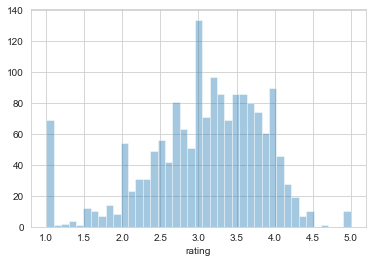

In [75]:
sns.set_style('whitegrid')
sns.distplot(MLdf_cleansed['rating'],bins=41,kde=False,norm_hist=False)

Normally distributed around 3-3.5 with ouliers in 1 and 5

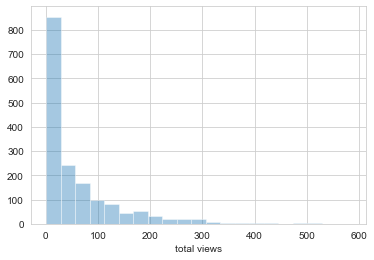

In [69]:
sns.distplot(MLdf_cleansed['total views'],bins=21,kde=False,norm_hist=False)

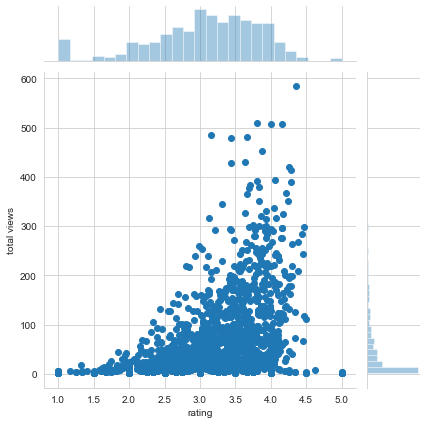

In [71]:
sns.jointplot('rating','total views',data=MLdf_cleansed)

In [72]:
MLdf_cleansed.describe()

,rating,total views
count,1664.000000,1664.000000
mean,3.077010,60.097957
std,0.780411,80.963482
min,1.000000,1.000000
25%,2.665094,7.000000
50%,3.162132,27.000000
75%,3.651808,80.250000
max,5.000000,584.000000


As we can see the data is hevily right skewed wrt to number of views

In [79]:
MLdf_cleansed.corr()

,rating,total views
rating,1.000000,0.430989
total views,0.430989,1.000000


We see that there is good corelation between rating and number of views.Better movie ,better rating ,more views

Creating Matrix for recommendation systems

In [77]:
MovieMatrix=MLdf_merged.pivot_table(index='user_id',columns='movie_name',values='rating')

In [78]:
MovieMatrix.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 944 entries, 0 to 943
Columns: 1664 entries, 'Til There Was You (1997) to Á köldum klaka (Cold Fever) (1994)
dtypes: float64(1664)
memory usage: 12.0 MB


Now the matrix is ready .Lats say we saw **The usual suspects** movie. Ands wantour model to recommend similar movies.we use IBCF( Movie based corealation to get this 5 recommendations)

In [92]:
MLdf_cleansed.loc['Usual Suspects, The (1995)']

rating           4.385768
total views    267.000000
Name: Usual Suspects, The (1995), dtype: float64

In [93]:
TheUsualSuspects=MovieMatrix['Usual Suspects, The (1995)']

In [123]:
similar_to_TheUsualSuspects=MovieMatrix.corrwith(TheUsualSuspects,axis=0,drop=True)

In [126]:
similar_to_TheUsualSuspectsdf=pd.DataFrame(similar_to_TheUsualSuspects,columns=['Corealation'])
similar_to_TheUsualSuspectsdf.dropna(axis=0,inplace=True)

In [130]:
similar_to_TheUsualSuspectsdf.sort_values('Corealation',ascending=False).head()

,Corealation
movie_name,
Drunks (1995),1.0
"Cement Garden, The (1993)",1.0
"Forbidden Christ, The (Cristo proibito, Il) (1950)",1.0
"Pompatus of Love, The (1996)",1.0
Gang Related (1997),1.0


we see that there are other movies we perfect corealation with our movie which is highly improbable.
This is occuring because these movies are rated by only few users who also rate The usual suspect as seen below.

In [135]:
MovieMatrix[['Usual Suspects, The (1995)','Drunks (1995)']].dropna()

movie_name,"Usual Suspects, The (1995)",Drunks (1995)
user_id,,
201,4.0,2.0
747,4.0,2.0
833,5.0,3.0


The probability of this is very high, sine we saw that the the data is heavily right skewed with the number of views.So taking number of views into consideration can give us thebest recommended movies. Basd on the plots we take number of views=>100

In [139]:
similar_to_TheUsualSuspectsdf=similar_to_TheUsualSuspectsdf.join(MLdf_cleansed)

Now we have the recommender system ready for movies similar to THe usual suspects

In [141]:
similar_to_TheUsualSuspectsdf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1323 entries, 1-900 (1994) to unknown
Data columns (total 3 columns):
Corealation    1323 non-null float64
rating         1323 non-null float64
total views    1323 non-null int64
dtypes: float64(2), int64(1)
memory usage: 81.3+ KB


Getting the similar movies

In [145]:
similar_to_TheUsualSuspectsdf[similar_to_TheUsualSuspectsdf['total views']>=100].sort_values(by='Corealation',ascending=False).head()

,Corealation,rating,total views
movie_name,,,
"Usual Suspects, The (1995)",1.000000,4.385768,267
Alien: Resurrection (1997),0.404007,3.096774,124
Cold Comfort Farm (1995),0.390026,3.824000,125
Sling Blade (1996),0.383882,4.198529,136
L.A. Confidential (1997),0.381204,4.161616,297
